In [1]:
from copy import copy
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

from rastermap import Rastermap

force_cpu = True
device = torch.device("cpu" if force_cpu else "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [2]:
def rowwise_corrcoef(X: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
    """
    Pearson correlations between every row of X (shape pxn)
    and every row of Y (shape qxn).  Returns a (pxq) matrix.
    """
    if X.shape[1] != Y.shape[1]:
        raise ValueError("X and Y must have the same number of observations (columns)")
    
    Xc = X - X.mean(dim=1, keepdim=True)
    Yc = Y - Y.mean(dim=1, keepdim=True)
    cov = (Xc @ Yc.T) / (X.shape[1] - 1)
    std_x = torch.linalg.norm(Xc, dim=1) / (X.shape[1] - 1) ** 0.5
    std_y = torch.linalg.norm(Yc, dim=1) / (Y.shape[1] - 1) ** 0.5
    return cov / std_x[:, None] / std_y[None, :]

In [3]:
vhat = 500 ## scales firing rate
tau = 20 ## 20ms exponential decay time constant
beta = 0.1  ## learning rate 0.05
prob_nonrw = 0.02 ## probability of not getting reward
eta0 = 10 ## refractory reduction scaling
tau_ref = 5 ## refractory reduction time constant
ref_time = 10 ## refractory time
baseline=10

NPS = 12 ## afferent neurons per stimuli
K = 100 ## recurrent neurons
W_std = 3.5
V_std = 2.5

input_fr = 100  ## input neuron firing rates
num_trials = 4000
each_obs_time = 20 ## each observation is shown for 20ms

trial_inputs = torch.stack([
    torch.tensor([1,1,1,1,1,1,2,2,2,2,1,1,1,4,6,1,1,1,5,5,1,1,7,0,0,0]),
    torch.tensor([1,1,1,1,1,1,3,3,3,3,1,1,1,4,4,1,1,1,5,6,1,1,7,0,0,0]),
])

num_trial_types = trial_inputs.shape[0]
num_obs = trial_inputs.shape[1]
num_stimuli = len(torch.unique(trial_inputs.view(-1)))
N = num_stimuli * NPS

inputs_active = torch.zeros(num_trial_types, num_obs, num_stimuli, requires_grad=False)
inputs_active = torch.scatter(inputs_active, dim=2, index=trial_inputs.unsqueeze(2), value=input_fr)
input_rates = torch.repeat_interleave(inputs_active, NPS, dim=2).to(device)

In [4]:
trial_type = torch.randint(0, 2, (num_trials, )).to(device)

b = baseline*torch.ones(K).to(device)

# Initialize weights
W = torch.maximum(torch.randn(K,N) * W_std, torch.zeros(K,N)).to(device) ## feedforward 
V = torch.maximum(torch.randn(K,K) * V_std, torch.zeros(K,K)).to(device)  ## recurrent 

# Store all membrane potentials
vall = torch.zeros(num_trials, num_obs, K).to(device)

In [5]:
x_filtered = torch.zeros(N).to(device)
v_filtered = torch.zeros(K).to(device)
v_potential = torch.zeros(K).to(device)
x_refractory = torch.zeros(N).to(device)
v_refractory = torch.zeros(K).to(device)
time_since_spike = 7 * torch.ones(K).to(device)
for trial in tqdm(range(num_trials)):
    for obs in range(num_obs):
        # When we get to the 6 type -- probabilisitically use the no-reward observation
        # (Which is always the previous observation independent of the trial type)
        use_obs = copy(obs)
        if trial_inputs[trial_type[trial], obs] == 6:
            if torch.rand(1) < prob_nonrw:
                use_obs = copy(obs - 1)

        for t in range(each_obs_time):

            input_over_threshold = torch.rand(N).to(device) < (input_rates[trial_type[trial], use_obs, :] / 1000)
            input_spiking = input_over_threshold & (x_refractory == 0)

            # Update membrane potential and refractory period for inputs
            x_refractory[input_spiking] = ref_time
            x_filtered = torch.exp(torch.tensor(-1/tau))*(x_filtered + 1*input_spiking)

            # Calculate firing rate of recurrent neuron 
            eta = eta0 * torch.exp(-time_since_spike/tau_ref).to(device)
            v_potential = (W @ x_filtered) + (V @ v_filtered) + b - eta
            v_spike_probability = vhat * torch.exp(v_potential - torch.logsumexp(v_potential, dim=0, keepdim=True))
            neuron_over_threshold = torch.rand(K).to(device) < v_spike_probability / 1000
            neuron_spiking = neuron_over_threshold & (v_refractory == 0)

            # Update membrane potential and refractory period for recurrent neurons
            v_refractory[neuron_spiking] = ref_time
            time_since_spike[neuron_spiking] = -1
            v_filtered = torch.exp(torch.tensor(-1/tau))*(v_filtered + 1*neuron_spiking)

            # Implement weight updates (only do this on spiking neurons!!!!)
            dW = beta * (torch.exp(-W) * x_filtered - 0.1) * neuron_spiking.view(-1, 1)
            dV = beta * (torch.exp(-V) * v_filtered - 0.1) * neuron_spiking.view(-1, 1)
            W = torch.maximum(W + dW, torch.zeros_like(W))
            V = torch.maximum(V + dV, torch.zeros_like(V))
            V[torch.arange(K), torch.arange(K)] = 0  ## no autapse

            # Reduce refractory period
            x_refractory = torch.max(x_refractory - 1, torch.tensor(0))
            v_refractory = torch.max(v_refractory - 1, torch.tensor(0))
            time_since_spike = time_since_spike + 1

            # Store membrane potential
            vall[trial, obs] += v_spike_probability / each_obs_time

100%|██████████| 4000/4000 [15:00<00:00,  4.44it/s]


In [8]:
np.save("vmeans.npy", vmeans)

2025-05-20 12:18:33,744 [INFO] normalizing data across axis=1
2025-05-20 12:18:33,746 [INFO] projecting out mean along axis=0
2025-05-20 12:18:33,747 [INFO] data normalized, 0.00sec
2025-05-20 12:18:33,748 [INFO] sorting activity: 100 valid samples by 52 timepoints
2025-05-20 12:18:33,755 [INFO] n_PCs = 40 computed, 0.01sec
2025-05-20 12:18:33,758 [INFO] 10 clusters computed, time 0.01sec
2025-05-20 12:18:33,769 [INFO] clusters sorted, time 0.02sec
2025-05-20 12:18:33,778 [INFO] clusters upsampled, time 0.03sec
2025-05-20 12:18:33,779 [INFO] rastermap complete, time 0.03sec


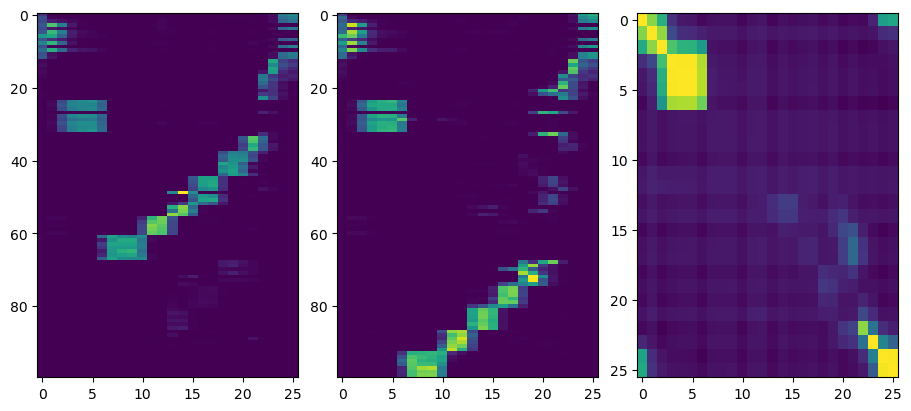

In [7]:
vmeans = torch.zeros(num_trial_types, num_obs, K)
for ttype in range(num_trial_types):
    idx_trial_type = ttype == trial_type
    vmeans[ttype] = torch.mean(vall[idx_trial_type], dim=0)

cc_matrix = rowwise_corrcoef(vmeans[0], vmeans[1])


# fit rastermap
data = np.array(torch.cat([vmeans[0], vmeans[1]], dim=0))
model = Rastermap(n_PCs=40, n_clusters=10, 
                  locality=0.75, time_lag_window=1).fit(data.T)

y = model.embedding # neurons x 1
isort = torch.tensor(model.isort)

fig, ax = plt.subplots(1, 3, figsize=(9, 4), layout='constrained')

ax[0].imshow(vmeans[0].T[isort], aspect="auto", interpolation="none")
ax[1].imshow(vmeans[1].T[isort], aspect="auto", interpolation="none")
ax[2].imshow(cc_matrix, aspect="auto")
plt.show()